In [1]:
from fastai.vision import *
import json
from darwin.utils import parse_darwin_annotation,convert_polygons_to_mask,convert_polygons_to_sequences
import darwin.datatypes as dt
from skimage import io
import warnings
warnings.filterwarnings("ignore")
import tqdm
from fastai.callbacks import LossMetrics,SaveModelCallback

In [2]:
#Read data
df=pd.read_csv('./newdata.csv')
for i in range(len(df)):
    if df.iat[i,1]=='Viral':
        if df.iat[i,2]==1:
            df.iat[i,1]='Covid'
        else:
            df.iat[i,1]='ViralN'
            
path='/home/staff/xin/Downloads/COVID/data2/clahe/'
src=ImageList.from_df(df,path,convert_mode='L').split_by_rand_pct(seed=1).label_from_df('covid')
data=(src.transform(get_transforms(do_flip=False,max_rotate=None),size=224).databunch(bs=12)).normalize(([0.5], [0.25]))

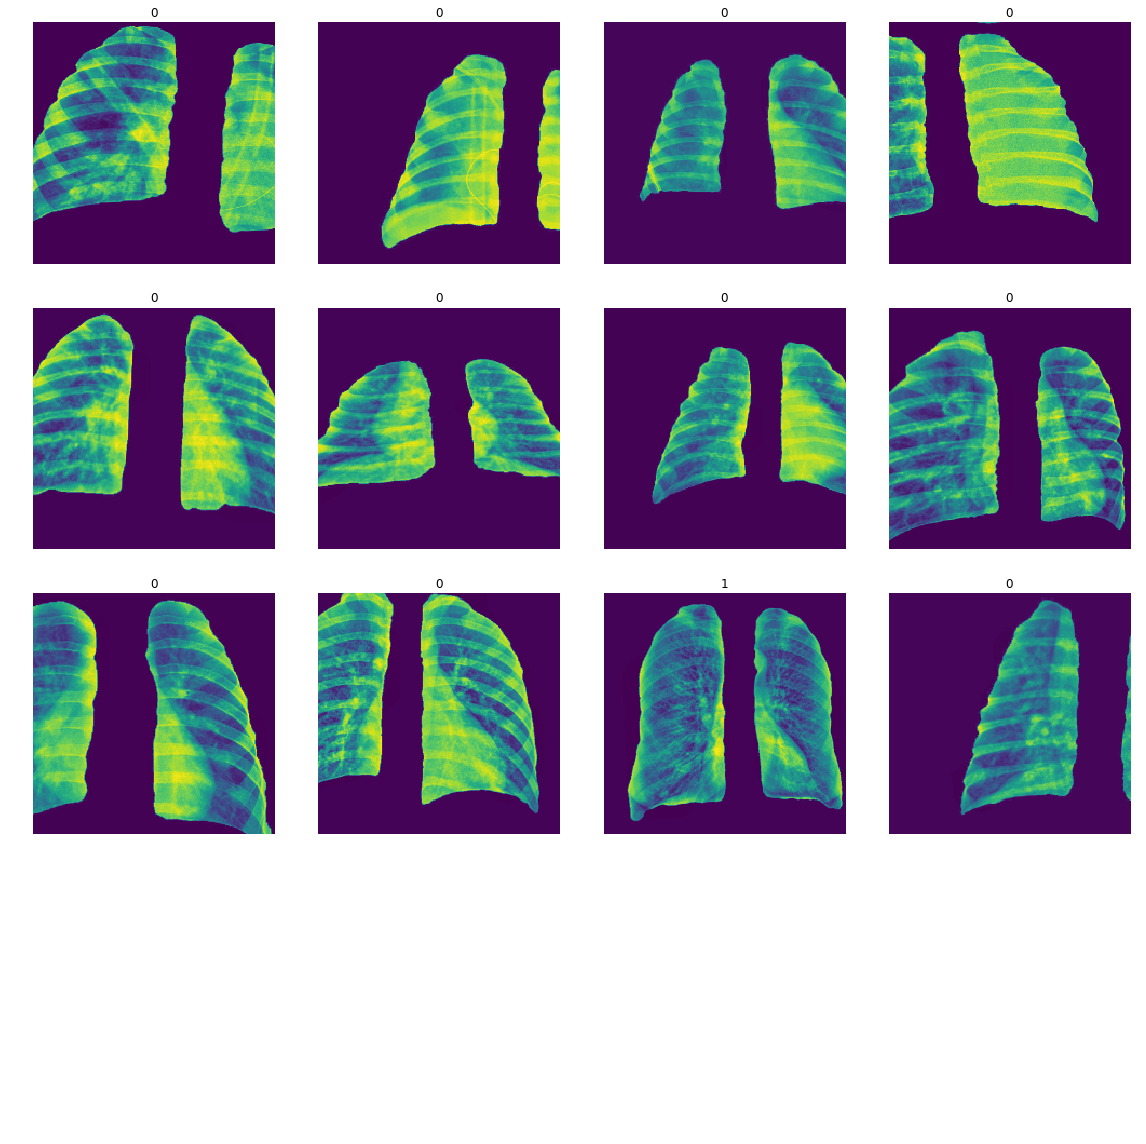

In [3]:
data.show_batch()

In [4]:
## Model 
class UnetResnet34(nn.Module):
    def __init__(self,
                 num_classes=3,
                 num_filters=32,
                 pretrained=True,
                 is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)        
        
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)
        self.encoder2 = torchvision.models.resnet34(pretrained=pretrained)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4
        self.avgpool = self.encoder.avgpool
        self.fc=nn.Linear(in_features=512, out_features=data.c, bias=True)
        
        

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = conv_layer(num_filters, num_filters)
        self.trans = conv_layer(num_filters,2,1,leaky=0.1)
        self.trans2 = conv_layer(2,3,1)
        self.Sig=SigmoidRange(-2,2)
        self.conv6 = nn.Sequential(self.encoder2.conv1,
                                   self.encoder2.bn1,
                                   self.encoder2.relu,
                                   self.pool)

        self.conv7 = self.encoder2.layer1

        self.conv8 = self.encoder2.layer2

        self.conv9 = self.encoder2.layer3

        self.conv10 = self.encoder2.layer4
        self.avgpool2 = self.encoder2.avgpool
        self.fc2=nn.Linear(in_features=512, out_features=data.c, bias=True)
                
    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
#         print(conv5.shape)
        out1=self.avgpool(conv5)
        out1 = out1.reshape(out1.size(0), -1)
        out1=self.fc(out1)
        center = self.center(self.pool(conv5))
#         print(center.shape)
        dec5 = self.dec5(torch.cat([center, conv5], 1))
#         print(dec5.shape)
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         print(dec4.shape)
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         print(dec3.shape)
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         print(dec2.shape)
        dec1 = self.dec1(dec2)
#         print(dec1.shape)
        dec0 = self.dec0(dec1)
        newx=self.Sig(self.trans2(self.trans(dec0)))
        
        conv6 = self.conv6(newx)
        conv6 = self.conv7(conv6)
        conv6 = self.conv8(conv6)
        conv6 = self.conv9(conv6)
        conv6 = self.conv10(conv6)
        out2=self.avgpool2(conv6)
        out2 = out2.reshape(out2.size(0), -1)
        out2=self.fc2(out2)
        return out1,out2

In [8]:
class FeatureLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.metric_names = ['aloss','bloss']
        self.aloss=CrossEntropyFlat()
#         self.bloss=nn.CosineSimilarity(dim=1, eps=1e-6)
    
    def forward(self, input, target):
        target=target.long()
        aloss=self.aloss(input[0],target)
        bloss=self.aloss(input[1],target)
#         bloss=torch.sigmoid(input[1])
#         bloss=bloss[range(len(target)),target].mean()
        loss=0.6*aloss+0.4*bloss
        outloss=[aloss,bloss]   
        self.metrics=dict(zip(self.metric_names,outloss))
        return loss
def newacc(input, target):
    return accuracy(input[0],target)

In [6]:
gc.collect()
learn=None
model=None
learn=Learner(data,model=UnetResnet34(),loss_func=FeatureLoss(),metrics=[acc1,acc2],callback_fns=LossMetrics).to_fp16()

In [ ]:
#Model train
learn.fit_one_cycle(100,slice(1e-4))

Visualization explanation

In [7]:
# Vis layer
def Gramdata(m,inputs,c):
    layer=m[0]
    with hook_output(layer) as hook_a:
        with hook_output(layer, grad= True) as hook_g:
            preds = m(inputs)
            preds[0,c].backward()
    acts = hook_a.stored[0].cpu()
#     print(acts2.shape)
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult


def reduce_channels_sequare(heatmap):
    channel1 = heatmap[0,0].cpu()
    channel2 = heatmap[0,1].cpu()
    channel3 = heatmap[0,2].cpu()
    new_heatmap = np.sqrt((channel1*channel1)+(channel2*channel2)+(channel3*channel3)) 
    return new_heatmap


In [ ]:
# load the model
model2=UnetResnet34()
model2.load_state_dict(torch.load('/home/staff/xin/Downloads/COVID/data2/clahe/models/segresult_15.pth')['model'])
model2=model2.cuda().eval()
layer1=model2.trans2


In [ ]:
# load image
image2=path2+df.name[idx]
raw=open_image(image.replace('clahe','img')).data.numpy().transpose(1,2,0)
temp2=PIL.Image.open(image).resize((512,512), resample=PIL.Image.BILINEAR).convert('RGB')
# Classnum=int(classname.split('.')[0])-1
xb=normalize(pil2tensor(temp2,np.float32).div_(255)).unsqueeze(0).cuda()

with hook_output(layer1) as hook_a:
    preds = model2(xb)
segment=reduce_channels_sequare(Sig(hook_a.stored))



In [ ]:
#Display

plt.imshow(raw)
plt.imshow(segment,alpha=1,extent=(0,raw.shape[1],raw.shape[0],0),
              interpolation='bilinear',cmap=my_cmap)